In [75]:
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from glob import glob
import random

In [76]:
class ImagePair(object):
    def __init__(self, number, root_dir='data'):
        self._number = number
        self.path = root_dir + '/brain_simulated_t1w_mri'
        self.img_fname = '23-Aug-2021_Ernst_labels_{:06d}_' \
                         '3T_T1w_MPR1_img_act_1_contrast_1'.format(self._number)

    def LR_HR_fnames(self):
        LR_suff = '_Res_2_2_2_img.nii.gz'
        LRf = path.join(self.path, 'LR', self.img_fname + LR_suff)
        HR_suff = '_Res_1_1_2_img.nii.gz'
        HRf = path.join(self.path, 'HR', self.img_fname + HR_suff)
        return LRf, HRf

    def img(self):
        LR_fname, HR_fname = self.LR_HR_fnames()
        self.LR = nib.load(LR_fname)
        self.HR = nib.load(HR_fname)
        img_pair = np.stack((self.LR.get_fdata(), self.HR.get_fdata()), axis=0)
        return img_pair

    def info(self):
        img_info = {
            'LR': self.LR.header,
            'HR': self.HR.header
        }
        return img_info

In [77]:
def data_split(dataset, split=[.7,.15,.15], root_dir='data',
               randomseed = 7886462529168327085):
    random.seed(randomseed)
    path = root_dir + '/brain_simulated_t1w_mri/HR/'
    fnames = glob(path + '*.nii.gz')
    ids = sorted(list(map(int, [(fnames[i][-60:-54]) for i in range(len(fnames))])))
    if dataset == 'training':
        ids_split = random.sample(ids, int(np.floor(split[0]*len(ids))))
    elif dataset == 'validation':
        ids_split = random.sample(ids, int(np.floor(split[1]*len(ids))))
    imgs = list()
    for num in tqdm(ids_split, desc='Load {} set\t'.format(dataset)):
        ImgPair = ImagePair(num, root_dir=root_dir)
        data = ImgPair.img()
        for i in range(data.shape[3]):
            slice = {'img': data[:,:,:,i].astype(np.float32),
                     'id': num,
                     'slice': i}
            imgs.append(slice)
    return imgs

In [78]:
class ImagePairDataset(Dataset):
    def __init__(self, dataset, root_dir='data', transform=None):
        self._root_dir = root_dir
        self.transform = transform

        self._imgs = data_split(dataset,
                                split = [.7,.15,.15],
                                root_dir=root_dir,
                               )
        self._idcs = np.arange(len(self._imgs))

    def __len__(self):
        return len(self._idcs)

    def __getitem__(self, idx):

        img_idx = self._idcs[idx]
        img = self._imgs[img_idx]

        sample = {'LR': img['img'][0],
                  'HR': img['img'][1],
                  'id': 'Im_{}-Slc_{}'.format(img['id'], img['slice']),
                  }

        if self.transform:
            sample = self.transform(sample)

        return sample


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b'          '
db_name         : b'                  '
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 32
dim             : [  3 224 224  69   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'                                                                                '
aux_file        : b'                        '
qform_code      : unknown
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quater

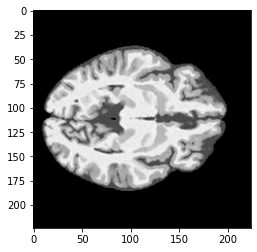

In [79]:
num = 100206
img = ImagePair(number=num, root_dir='data')
slice = img.img()[1,:,:,30]
plt.imshow(slice, cmap='gray')
print(img.info()['HR'])

In [80]:
tra_set = ImagePairDataset('training')
val_set = ImagePairDataset('validation')

Load validation set	: 100%|█████████████████████████████████████████| 30/30 [00:02<00:00, 13.27it/s]


Length of training set: 	9453
Length of validation set: 	2033


(-0.5, 223.5, 223.5, -0.5)

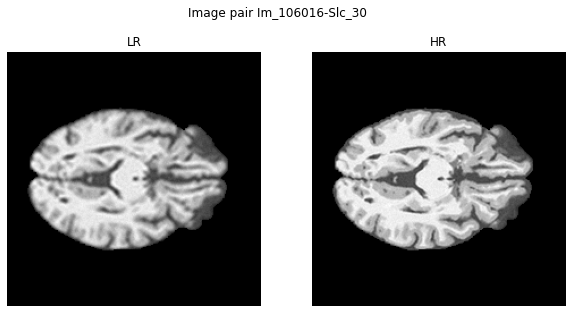

In [99]:
print('Length of training set: \t{}\nLength of validation set: \t{}'
      .format(len(tra_set),len(val_set)))

num=30
sample=tra_set[num]
title = 'Image pair {}'.format(sample['id'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.set_facecolor('white')
fig.suptitle(title)
ax1.imshow(sample['LR'],cmap='gray')
ax1.set_title('LR')
ax1.axis('off')
ax2.imshow(sample['HR'],cmap='gray')
ax2.set_title('HR')
ax2.axis('off')